# Audio Pre-processing

Autoreload notebook

In [1]:
%load_ext autoreload
%autoreload 2

>> #### Import required packages

In [17]:
!pip install pydub

  Using cached pydub-0.25.1-py2.py3-none-any.whl (32 kB)


In [18]:

# Import packages

import pandas as pd
import numpy as np
import random
import os
import sys

#notebook reproducible 
np.random.seed(42)
random.seed(42)

# Directory listing
from glob import glob

# Visualization
import matplotlib.pylab as plt
import seaborn as sns

# Audio Processing
import librosa
import librosa.display
import IPython.display as ipd
from pydub import AudioSegment
import matplotlib.pyplot as plt
from scipy.io import wavfile #for audio processing
#for pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import warnings
warnings.filterwarnings("ignore")

# Color Palettes

from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

>> #### Import modules

In [43]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from data_prepro import AudioUtil
from data_load import DataLoader

In [21]:
sys.path.append(os.path.abspath(os.path.join('data')))

PATH = '../data/train/wav/'
prep = AudioUtil()
load = DataLoader(data_dir=PATH, sample_rate=16000, max_duration=12.0)

In [26]:
# import os
# import sys
# import librosa
# import numpy as np
# import matplotlib.pyplot as plt
# sys.path.insert(0,'../scripts/')
# from data_loader import DataLoader
# from resize_audio import resize_audio

In [60]:
dl = DataLoader("../data/train/wav")
dl

In [73]:
PATH = '../data/train/wav/'
prep = AudioUtil()
load = DataLoader(data_dir=PATH, sample_rate=16000, max_duration=12.0)

In [62]:
# amharic_audio_files = glob("../data/AMHARIC/data/train/wav/*.wav")
amh_audios = load.get_wav_files()[:3]

In [63]:
amh_audios

['../data/train/wav\\tr_10000_tr097082.wav',
 '../data/train/wav\\tr_10001_tr097083.wav',
 '../data/train/wav\\tr_10002_tr097084.wav']

In [64]:
ipd.Audio(amh_audios[2])

In [65]:
y, sr = librosa.load(amh_audios[1])
y

array([-0.11713821, -0.13261142, -0.11196302, ..., -0.12805086,
       -0.12876439,  0.        ], dtype=float32)

<AxesSubplot:title={'center':'Raw Data Sample'}>

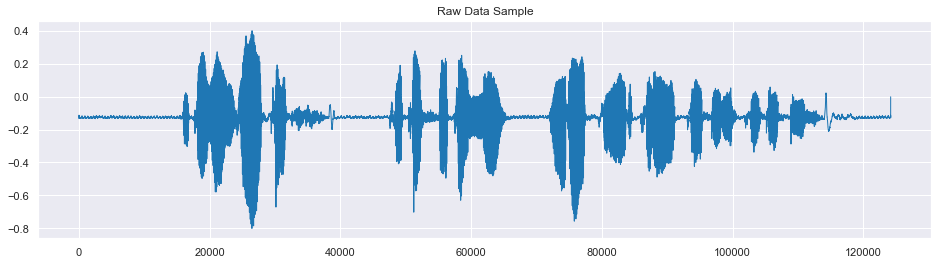

In [66]:
sns.set_style("darkgrid")
pd.Series(y).plot(figsize=(16, 4), lw=1, title="Raw Data Sample", color=color_pal[0])

In [67]:
y_trimmed, _ = librosa.effects.trim(y, top_db=20)

<AxesSubplot:title={'center':'Raw Data Sample'}>

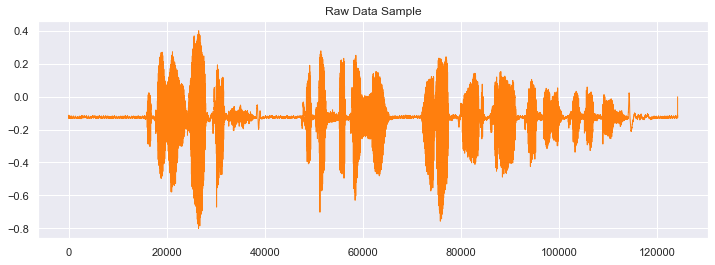

In [68]:
sns.set_style("darkgrid")
pd.Series(y_trimmed).plot(figsize=(12, 4), lw=1, title="Raw Data Sample", color=color_pal[1])

In [ ]:
# audio_files_all = load.get_wav_files()

In [ ]:
# audio_files_all[:5]

>>TEXT

In [70]:
# Load transcription and save as json
audio_path, text, duration = load.load_transcription(file_path='../data/train/text', dest_path='../data/train_corpus.json', save=True)

In [71]:
load_path = "../data/train/text"
load.generate_meta_data(load_path, '../data/trainsr_corpus.csv')

Meta data creatwd successfully


>> Convert to Channels

In [74]:
prep.convert_to_stereo(audio_path=amh_audios, dest_path='../data/train/', new_channel=2)

>> Create meta data to pass the path of the audios to resample it to 44.1 KHZ

In [ ]:
meta_data=pd.read_csv("../data/train/trsTrain.txt",sep="\t",header=None)
pipe = Pipeline(steps = [("metadata", FunctionTransformer(prep.create_meta_data, kw_args={"column1":'Transcript', "column2": 'audio'}))])
meta_pipe = pipe.fit_transform(meta_data)
meta_data

>> Resampling

In [ ]:
# resampling any loaded audio files to 44.1KHZ 
prep.resample(meta_data, 'audio')

>> Resize Audio

Load 100 audios

In [ ]:
audios, max_duration = dl.load_audios(False,10)

Plot the durations of the hundred audio files

In [ ]:
train_audio_path = '../data/train/wav/'
durations = []
labels = os.listdir(train_audio_path)
for i,label in enumerate(labels):
    if i > 100:
        break
    samples, sample_rate = librosa.load(train_audio_path+label, sr=44100, mono=False)
    durations.append(len(samples)/sample_rate)
durations = np.array(durations)
plt.hist(durations)

In [ ]:
def resize_audio(audios,max_duration):
    resized_audios = {}
    for label in audios:
        resized_audios[label] = librosa.util.fix_length(audios[label],size=int(max_duration*44100))
    return resized_audios

In [ ]:
resized_audios = resize_audio(audios,max_duration)

In [ ]:
ipd.Audio(list(resized_audios.values())[2], rate=44100)

In [ ]:
ipd.Audio(list(audios.values())[2], rate=44100)

>> Data Augumentation

In [ ]:
demo_audio = list(audio_files.keys())[1]

In [ ]:
def augment_audio(audios : dict, sample_rate : int) -> dict:
  
#shift the wave by sample_rate/10 factor.
#audios - a dictionary mapping the wav file names to the sampled audio array
#sample_rate - the sample rate for the audio
#audios - a python dictionary mapping the wav file names to the augmented audio samples
  for name in audios:
    audios[name] = np.roll(audios[name], int(sample_rate/10))
  return audios

augment_audio(audio_files, sample_rate)[demo_audio].shape

In [ ]:
# def plot_spec(data:np.array,sr:int) -> None:
#   '''
#   Function for plotting spectrogram along with amplitude wave graph
#   '''
  
#   fig, ax = plt.subplots(1,2,figsize=(15,5))
#   ax[0].title.set_text(f'Shfiting the wave by Times {sr/10}')
#   ax[0].specgram(data,Fs=2)
#   ax[1].set_ylabel('Amplitude')
#   ax[1].plot(np.linspace(0,1,len(data)), data)

wav_roll = np.roll(samples,int(sample_rate/10))
plot_spec(data=wav_roll,sr=sample_rate)
ipd.Audio(wav_roll,rate=sample_rate)

>> Feature Extraction

Every audio signal consists of many features. However, we must extract the characteristics that are relevant to the problem we are trying to solve. The process of extracting features to use them for analysis is called feature extraction. This notebook loads an audio using Librosa library and defines a function to generate spectograms and MFCCs. Spectograms and MFCCs are the features we are intrested in in the audios.

>> Utility Functions

We define utility functions to help us in feature extraction
The utility functions defined below are:
  

1.   **spectogram()** - Computes the spectogram for an audio signal
2.   **plot_spectogram()** - This function plots a normalized spectogram of an audio signal
3.   **mfcc()** - This function computes the Mel frequency cepstral coefficients (MFCCs) of an audio signal
4.   **plot_mfcc()** - This function plots the mfccs of an audio signal

In [ ]:
train_audio_path = '../data/train/wav/'
audio, rate = librosa.load(train_audio_path+'tr_10_tr01010.wav')
print("audio: ", audio)
print("Sampling rate: ", rate)

In [ ]:
x,freqs = prep.spectrogram(audio)
freqs

>> spectogram extraction for our selected audio

A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform. Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time.

A spectrogram is usually depicted as a heat map, i.e., as an image with the intensity shown by varying the color or brightness.

We can display a spectrogram using. librosa.display.specshow.
We compute the spectogram of the audio signal we loaded and plot the spectogram feature

In [ ]:
x,freqs= prep.spectrogram(audio)  # compute the spectrogram of the audio
prep.plot_spectrogram_feature(x)  # plot the spectogram

>> MFCC extraction for our selected audio

WE compute of the loaded signal and plot the mfcc

In [ ]:
from python_speech_features import mfcc
mfccs = mfcc(audio, rate) # compute the mfcc
prep.plot_mfcc(mfccs, rate)

>> Other spectral Feature extraction

1. **Spectral Centroid**

The spectral centroid indicates at which frequency the energy of a spectrum is centered upon or in other words It indicates where the ” center of mass” for a sound is located. 

In [ ]:
def spectral_centroids(audio, sampling_rate):
  """
  computes the spectral centroid for each frame in an audio signal and the time variable for visualization
  """
  spectral_centroids = librosa.feature.spectral_centroid(audio, sr=sampling_rate)
  frames = range(len(spectral_centroids[0]))
  t = librosa.frames_to_time(frames)
  return spectral_centroids, t

Plotting the spectral centroid for our input signal we loaded

In [ ]:
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

In [ ]:
spectral_centroid, t = spectral_centroids(audio, rate)
spectral_centroid= spectral_centroid[0]

#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(audio, sr=rate, alpha=0.4)
#plt.figure(figsize=(12, 4))
plt.plot(t, normalize(spectral_centroid), color='b')

**2. Spectral Rolloff**

It is a measure of the shape of the signal. It represents the frequency at which high frequencies decline to 0. To obtain it, we have to calculate the fraction of bins in the power spectrum where 85% of its power is at lower frequencies.

In [ ]:
spectral_rolloff = librosa.feature.spectral_rolloff(audio+0.01, sr=rate)[0]
#plt.figure(figsize=(12, 4))
librosa.display.waveplot(audio, sr=rate, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

**3. Spectral Bandwidth**

The spectral bandwidth is defined as the width of the band of light at one-half the peak maximum (or full width at half maximum [FWHM]) and is represented by the two vertical red lines and λSB on the wavelength axis.

In [ ]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(audio+0.01, sr=rate)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(audio+0.01, sr=rate, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(audio+0.01, sr=rate, p=4)[0]
#plt.figure(figsize=(15, 9))
librosa.display.waveplot(audio, sr=rate, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))

**4. Chroma feature**

A chroma feature or vector is typically a 12-element feature vector indicating how much energy of each pitch class, {C, C#, D, D#, E, …, B}, is present in the signal. In short, It provides a robust way to describe a similarity measure between music pieces.

In [ ]:
chromagram = librosa.feature.chroma_stft(audio, sr=rate, hop_length=512)
#plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=512, cmap='coolwarm')